# universal estimator-exp-1

Let $f(d)$ be a one dimensional function, that returns a samples drawn from a univariate distribution (e.g., log-normal).

**Research question**: Is the prediction error $MAE(pred\_set , test\_set)$ decreases when the parameter search space gets smaller?

1. Generate a sample (256 observations) using $f$ e.g: $sample = f(d=0.92, size=256)$
2. Write a function: $estimator(f, sample)$ which learns the parameter $d$ of $f$ from the sample.

> - Init: search_space = [0, 1]
>
> - Iterate:
>   1. Generate synthetic data-set ( train / test ) using $f(d)$, $d \in ~ uniform(0, 1)$
>   2. Fit a DNN model to the training set, let:
>          e = mean_abs_error(pred-set, test-set)
>   3. Predict the parameter $d\_pred$ on the input sample
>          d_pred = model.predict(sample)
>   4. Narrow the search space:
>          pivot = d_pred
>          margin = 3 * std(e)
>          search_space = [ pivot-margin, pivot+margin ]
>   5. Stop when the search-space size reaches some fraction, e.g. 1/128, of the initial search space [0, 1]
>
> - Return:
>      - d_pred_array: array of d_pred produced in each iteration (3)
>      - search_spaces: array of search-spaces (4)
>      - pred-set, test-set

3. Plot a graph:
   - $x$: iteration #
   - $y$: error = MAE(pred-set, test-set)
   - Show that the error converges to a lower limit (asymptotically)

**Results**:

The experiment was run on the true parameter: $d\_true =$ 0.92 
As can be shown by the plots:
> $MAE(pred - test)$ decreases asymptotically as we narrow the search-space.

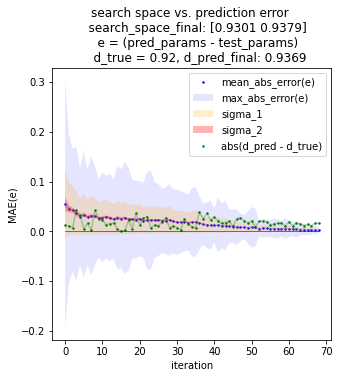

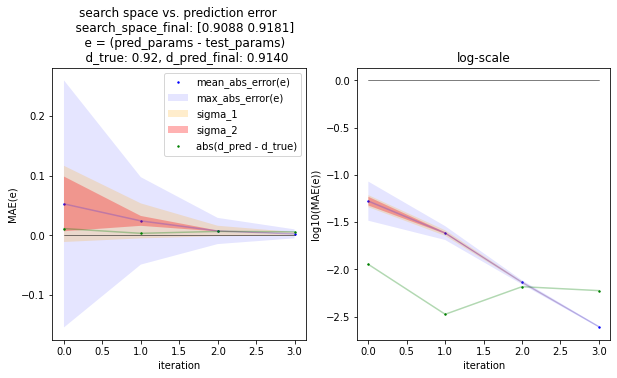

In [1]:
# import library
%run lib.ipynb
np.set_printoptions(precision=4)

In [2]:
from scipy import stats
from scipy.stats import lognorm

# sample from lognormal
def sample_lognormal(config, size):
    return lognorm.rvs(s=config, size=size, random_state=RANDOM_STATE)

def next_config(search_space):
    """
    return a (uniform) random parameter within search_space
    """
    low = search_space[0]
    high = search_space[1]
    return np.random.uniform(low, high, size=1)[0]

In [3]:
def MAE(e, axis=-1):
    """mean absolute error"""
    return np.mean(np.abs(e), axis=axis)

NUM_BINS = 346

def predict_d(f, sample, d_true, search_space, num_trials=1, N=1000):
    """
    Learn parameters of f, from sample.
    Arguments:
        - f: one dimensional function that gives the PMF of a univariate distribution.
        - sample: generated using f.
    """

    # number of observations in sample
    M = len(sample)
    N = N

    nbins = NUM_BINS
    
    # Generate a histogram for the input *sample*
    H_sample = np.histogram(sample, bins=nbins, range=(0,nbins), density=False)[0]
    H_sample = np.reshape(H_sample, (1, -1))
    
    # Iterate   
    d_pred_array = np.zeros(num_trials)
    for trial_idx in range(num_trials):

        # 1. Generate synthetic data-sets (train/test) using f (within search_space)
        # -----------------------------------------------------------------------------------------------
        print()
        print(f'search_space: {search_space} - trial ({trial_idx+1}/{num_trials})')
        print(f'generating data (M={M}, N={N})', end=', ')

        raw, H, params = generate_data(N=N, 
                                       M=M, 
                                       sample=f, 
                                       nextConfig=lambda: next_config(search_space),
                                       nbins=nbins,
                                       density=False, 
                                       apply_log_scale=False)

        H_train, H_test, train_params, test_params = train_test_split(H, 
                                                                      params, 
                                                                      test_size=0.25, 
                                                                      random_state=RANDOM_STATE)

        # 2. Fit a DNN model to train-set and predict on test-set
        # -----------------------------------------------------------------------------------------------

        # train
        print(f'training dnn model ...', end=' ')
        dnn_model, history = dnn_fit(X_train=H_train, y_train=train_params)

        # predict test
        pred_params = dnn_model.predict(H_test).flatten()

        # error
        e = pred_params - test_params
        
        # MAE(e), max_absolute_error(e)
        pred_params_MAE = MAE(e)
        test_MAX_abs_error = np.max( np.abs(e) )

        # 3. Predict the parameter (d_pred) on the input sample
        # -----------------------------------------------------------------------------------------------

        d_pred = dnn_model.predict(H_sample).flatten()[0]
        d_pred_array[trial_idx] = d_pred
        
        print(f'done. d_pred: {d_pred:.4f}')

    return d_pred_array, test_params, pred_params

In [4]:
def estimator_exp_1(f, sample, d_true):

    # experiment results
    res = {
        'search_space': [],
        'test_params': [],
        'pred_params': [],
        'd_true': d_true,
        'd_pred': [],
    }

    initial_search_space = np.array([0.0, 1.0])
    initial_search_space_width = initial_search_space[1] - initial_search_space[0]
    search_space = initial_search_space
    
    # Iterate
    it = 0
    while True:
        
        it += 1
        
        d_pred_array, test_params, pred_params = predict_d(f, 
                                                           sample, 
                                                           d_true, 
                                                           search_space, 
                                                           num_trials=10, 
                                                           N=1000)
        d_pred = np.mean(d_pred_array)

        print()
        if len(d_pred_array) > 1:
            print(f'*** avg(d_pred): {d_pred:.4f}', end=', ')
        else:
            print(f'*** d_pred: {d_pred:.4f}', end=', ')
        print(f'abs_error: {abs(d_pred - d_true):.4f}')
        
        # save results
        res['search_space'].append(search_space)
        res['test_params'].append(test_params)
        res['pred_params'].append(pred_params)
        res['d_pred'].append(d_pred)
        
        # Narrow the search space:
        pivot = d_pred

        margin_with_STD = True
#         margin_with_STD = False

        if margin_with_STD:
            std_factor = 1
#             std_factor = 2
#             std_factor = 3
            if len(d_pred_array) > 1:
                margin = std_factor * np.std(d_pred_array - d_true)
                print(f'pivot = d_pred: {pivot:.4f}, margin = {std_factor} * STD(d_pred) = {margin:.4f}')
            else:
                margin = std_factor * np.std(pred_params - test_params)
                print(f'pivot = d_pred: {pivot:.4f}, margin = {std_factor} * STD(pred_params) = {margin:.4f}')
        else:
            margin = test_MAX_abs_error
            print(f'pivot = d_pred: {pivot:.4f}, margin = test_MAX_abs_error = {margin:.4f}')
        
        # update search_space
#         next_search_space = np.array([ pivot - margin, pivot + margin ])
        next_search_space = np.array([ 
            max(search_space[0], pivot - margin), 
            min(search_space[1], pivot + margin)])
#         next_search_space = np.array([
#             max(initial_search_space[0], pivot - margin), 
#             min(initial_search_space[1], pivot + margin)])
        
        # if no change in search_space, narrow by epsilon
        if np.array_equal(search_space, next_search_space):
            epsilon = 0.0001
            print(f'no change in search_space. narrowing by epsilon: {epsilon:.4f}')
            search_space = np.array([search_space[0] + epsilon, search_space[1] - epsilon])
        else:
            search_space = next_search_space
        
        # stop condition: size of the search-space (high-low) is 1/128 of the original
        search_space_width = search_space[1] - search_space[0]
        search_space_shrink_factor = 1/128
        if search_space_width < search_space_shrink_factor * initial_search_space_width:
            break
            

    res['search_space'] = np.array(res['search_space'])
    res['test_params'] = np.array(res['test_params'])
    res['pred_params'] = np.array(res['pred_params'])
    res['d_pred'] = np.array(res['d_pred'])
    
    return res

## Plot

In [5]:
def plot_search_space_size_vs_d_pred_error(res):

    search_space = res['search_space']
    search_space_width = search_space[:,1] - search_space[:,0]
    search_space_final = search_space[-1]
    
    d_true = res['d_true']
    d_pred = res['d_pred']
    d_pred_final = d_pred[-1] # d_pred of the last (narrowest) search_space
    d_pred_abs_error = np.abs(d_pred - d_true)

    pred_params = res['pred_params']
    test_params = res['test_params']

    # errors in each iteration
    e = pred_params - test_params
    
    # num-iterations
    n = e.shape[0]
    
    # avg error of each iteration
    mu = np.mean(e, axis=1).reshape((n,-1))
    
    # STD in each iteration
    sigma_1 = np.std(e, axis=1)

    # sigma_2
    mu = np.mean(e, axis=1).reshape(n, 1)
    var_2 = 1/n * np.sum(np.square(np.square(e - mu) - np.square(sigma_1).reshape(n,1)), axis=1)
    sigma_2 = np.sqrt(var_2)

    # iteration number
    x = np.array(range(n))

    max_abs_error_e = np.max(np.abs(e), axis=1)
    
    # PLOT
    title = f'search space vs. prediction error \n\
    search_space_final: {search_space_final} \n\
    e = (pred_params - test_params) \n\
    d_true: {d_true}, d_pred_final: {d_pred_final:.4f}'
    
    fig, axes  = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    
    for ax in axes:

        # zero reference line
        ax.plot(x, np.zeros(n), zorder=2, c='black', linewidth=0.5)

        ax.set_xlabel('iteration')
        
        if ax == axes[0]:
            ax.set_title(title)
#             y1 = sigma_1
            y1 = MAE(e)
            y2 = d_pred_abs_error
            ax.set_ylabel('MAE(e)')
        else:
            ax.set_title('log-scale')
            y1 = np.log10(y1)
            y2 = np.log10(y2)
            ax.set_ylabel('log10(MAE(e))')

        ax.scatter(x, y1, zorder=1, s=2, c='blue', label='mean_abs_error(e)')
        ax.plot(x, y1, zorder=2, c='blue', alpha=0.2)

        # confidence_interval_1: MAE(e) +- max_abs_error(e)
        ax.fill_between(range(len(x)), 
                         y1 - max_abs_error_e, y1 + max_abs_error_e, 
                         facecolor='blue', alpha=0.1, label='max_abs_error(e)')

        # confidence_interval_2: MAE(e) +- sigma_1
        ax.fill_between(range(len(x)), 
                         y1 - sigma_1, y1 + sigma_1, 
                         facecolor='orange', alpha=0.2, label='sigma_1')

        # confidence_interval_3: MAE(e) +- sigma_2
        ax.fill_between(range(len(x)), 
                         y1 - sigma_2, y1 + sigma_2, 
                         facecolor='red', alpha=0.3, label='sigma_2')

        # y2 (d_pred)
        ax.scatter(x, y2, zorder=1, s=2, c='green', label='abs(d_pred - d_true)')
        ax.plot(x, y2, zorder=2, c='green', alpha=0.3)
    
        if ax == axes[0]:
            ax.legend(loc='upper right')
            
    plt.show()

## Fit (lognormal)


param true value: 0.95

search_space: [0. 1.] - trial (1/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.8398

search_space: [0. 1.] - trial (2/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 1.0097

search_space: [0. 1.] - trial (3/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 1.0878

search_space: [0. 1.] - trial (4/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.9403

search_space: [0. 1.] - trial (5/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.9374

search_space: [0. 1.] - trial (6/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.7921

search_space: [0. 1.] - trial (7/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.8366

search_space: [0. 1.] - trial (8/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.8651

search_space: [0. 1.] - trial (9/10)
generating data (M

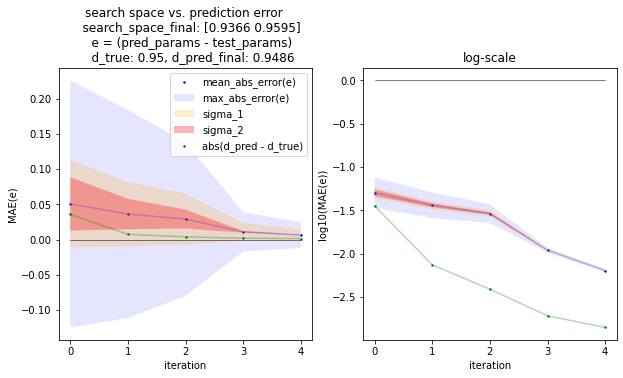


param true value: 0.85

search_space: [0. 1.] - trial (1/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.8932

search_space: [0. 1.] - trial (2/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.9228

search_space: [0. 1.] - trial (3/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.9259

search_space: [0. 1.] - trial (4/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.8854

search_space: [0. 1.] - trial (5/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.8113

search_space: [0. 1.] - trial (6/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.8615

search_space: [0. 1.] - trial (7/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.7527

search_space: [0. 1.] - trial (8/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.7596

search_space: [0. 1.] - trial (9/10)
generating data (M

generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.8488

search_space: [0.8451 0.8539] - trial (4/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.8491

search_space: [0.8451 0.8539] - trial (5/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.8505

search_space: [0.8451 0.8539] - trial (6/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.8486

search_space: [0.8451 0.8539] - trial (7/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.8480

search_space: [0.8451 0.8539] - trial (8/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.8519

search_space: [0.8451 0.8539] - trial (9/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.8498

search_space: [0.8451 0.8539] - trial (10/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.8474

*** avg(d_pred): 0.8492, abs_error: 0.0008
pivot = d_pred: 0

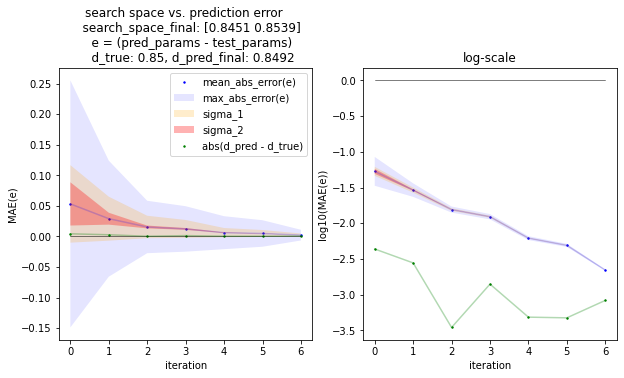


param true value: 0.65

search_space: [0. 1.] - trial (1/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.5947

search_space: [0. 1.] - trial (2/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.6572

search_space: [0. 1.] - trial (3/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.6125

search_space: [0. 1.] - trial (4/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.5537

search_space: [0. 1.] - trial (5/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.6318

search_space: [0. 1.] - trial (6/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.6066

search_space: [0. 1.] - trial (7/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.6288

search_space: [0. 1.] - trial (8/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.5913

search_space: [0. 1.] - trial (9/10)
generating data (M

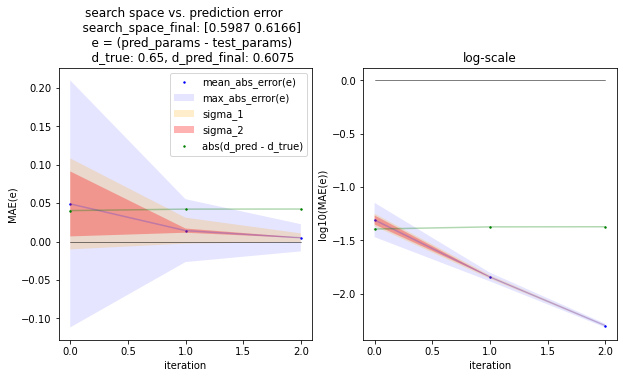


param true value: 0.45

search_space: [0. 1.] - trial (1/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.4486

search_space: [0. 1.] - trial (2/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.5184

search_space: [0. 1.] - trial (3/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.4697

search_space: [0. 1.] - trial (4/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.5038

search_space: [0. 1.] - trial (5/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.4583

search_space: [0. 1.] - trial (6/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.4674

search_space: [0. 1.] - trial (7/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.4790

search_space: [0. 1.] - trial (8/10)
generating data (M=256, N=1000), training dnn model ... done. d_pred: 0.5108

search_space: [0. 1.] - trial (9/10)
generating data (M

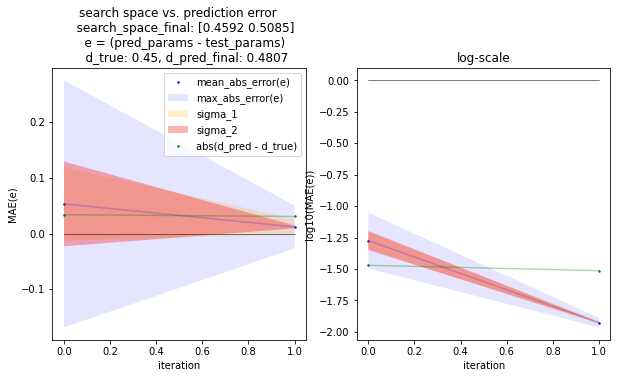

In [6]:
for d_true in [0.95, 0.85, 0.65, 0.45]:
    print()
    print(f'param true value: {d_true}')
    sample = sample_lognormal(config=d_true, size=256)
    res = estimator_exp_1(f=sample_lognormal, sample=sample, d_true=d_true)
    plot_search_space_size_vs_d_pred_error(res)